## Investigating Sentinel SAR data and snowdepth at Grand Mesa, Colorado
*Term Project for CUAHSI Microwave Radar Remote Sensing: Theory and Applications (GEOPH597) CUAHSI Virtual University*

**Victoria Ly** and **Steven Pestana** (University of Washington)
***
#### Data: 
- In situ snow depth measurements from three stations at Grand Mesa, Colorado
- [Sentinel-1 data from Google Earth Engine](https://developers.google.com/earth-engine/sentinel1)


#### References: 
Lievens, H., Demuzere, M., Marshall, H. P., Reichle, R. H., Brucker, L., Brangers, I., … De Lannoy, G. J. M. (2019). Snow depth variability in the Northern Hemisphere mountains observed from space. Nature Communications, 10(1), 1–12. https://doi.org/10.1038/s41467-019-12566-y

In [67]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

***
### Grand Mesa surface observations from three met stations, providing snow depth measurements througout the winter in 2017.

Load Grand Mesa West data

In [214]:
# Grand Mesa West data
filepath = r'met_data\MW-V5t_spestana.csv'
gm_west = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_west['datetime'] = pd.to_datetime(gm_west['TIMESTAMP (TS, )']) # timestamp string to pandas datetime
gm_west['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_west = gm_west.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_west_daily_median = gm_west
# Set the datetime column to this new data frame's index
gm_west_daily_median = gm_west_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_west_daily_median = gm_west_daily_median.resample('1D').median()
gm_west_daily_max = gm_west_daily_median.resample('1D').max()

Load Grand Mesa Middle data

In [215]:
# Grand Mesa West data
filepath = r'met_data\MM-V3t_spestana.csv'
gm_middle = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_middle['datetime'] = pd.to_datetime(gm_middle['TIMESTAMP(TS, )']) # timestamp string to pandas datetime
gm_middle['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_middle = gm_middle.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_middle_daily_median = gm_middle
# Set the datetime column to this new data frame's index
gm_middle_daily_median = gm_middle_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_middle_daily_median = gm_middle_daily_median.resample('1D').median()
gm_middle_daily_max = gm_middle_daily_median.resample('1D').max()

Load Grand Mesa (LSOS) data

In [216]:
# Grand Mesa East data
filepath = r'met_data\LSOS-V2t_spestana.csv'
gm_lsos = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_lsos['datetime'] = pd.to_datetime(gm_lsos['TIMESTAMP']) # timestamp string to pandas datetime
gm_lsos['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_lsos = gm_lsos.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_lsos_daily_median = gm_lsos
# Set the datetime column to this new data frame's index
gm_lsos_daily_median = gm_lsos_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_lsos_daily_median = gm_lsos_daily_median.resample('1D').median()
gm_lsos_daily_max = gm_lsos_daily_median.resample('1D').max()

Find dates where surface temperature is >= 0, set these as "melt dates":

In [219]:
threshold = 0
west_melt_dates = gm_west_daily_max.index[gm_west_daily_max['IRtarget_nadir1_C_Avg (C, Avg)']>=threshold].tolist()
middle_melt_dates = gm_middle_daily_max.index[gm_middle_daily_max['IRtarget_nadir1_C_Avg(C, Avg)']>=threshold].tolist()
lsos_melt_dates = gm_lsos_daily_max.index[gm_lsos_daily_max['IRtarget_nadir1_C_Avg (C, Avg)']>=threshold].tolist()

Plot daily median snow depths at all three sites:

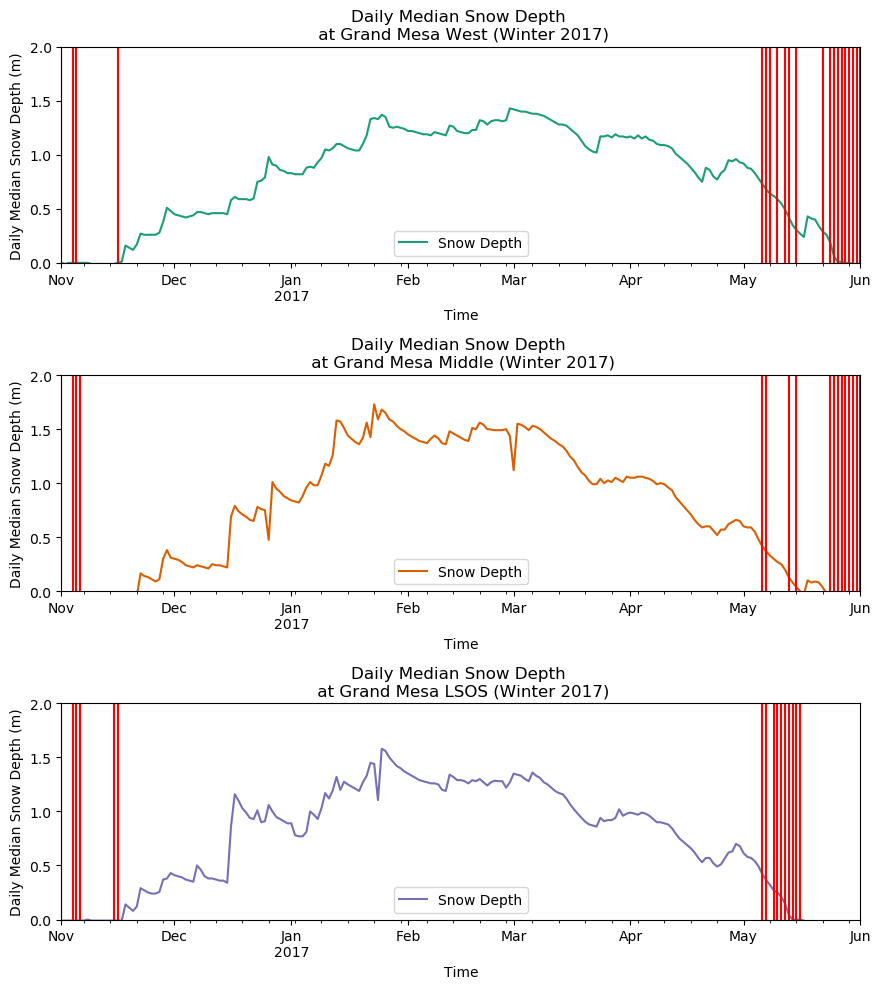

In [220]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')

# Plot daily median snow depths:
with plt.style.context('default'):
    fig, ax = plt.subplots(3,1,figsize=(9,10))

    ax[0].set_title('Daily Median Snow Depth \n at Grand Mesa West (Winter 2017)');
    gm_west_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#1b9e77', ax=ax[0], 
                              label='Snow Depth')
    for d in west_melt_dates:
        ax[0].axvline(x=d,c='r')

    ax[1].set_title('Daily Median Snow Depth \n at Grand Mesa Middle (Winter 2017)');
    gm_middle_daily_median.plot(y='Snow Depth(m, Avg)', 
                                c='#d95f02', ax=ax[1], 
                                label='Snow Depth')
    for d in middle_melt_dates:
        ax[1].axvline(x=d,c='r')

    ax[2].set_title('Daily Median Snow Depth \n at Grand Mesa LSOS (Winter 2017)');
    gm_lsos_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#7570b3', ax=ax[2], 
                              label='Snow Depth')  
    for d in lsos_melt_dates:
        ax[2].axvline(x=d,c='r')
    
    # format each subplot:
    for n in range(len(ax)):
        ax[n].set_ylim((0,2))
        ax[n].set_xlim((starttime,endtime))
        ax[n].set_ylabel('Daily Median Snow Depth (m)')
        ax[n].set_xlabel('Time')

    plt.tight_layout()
    plt.savefig('daily_median_snowdepth.png',dpi=300)

***
### Grand Mesa Sentinel-1 C-band radar observations.
Load data that was extracted using a [Google Earth Engine script](https://code.earthengine.google.com/4e7a5ba1fd7fcf0d87d9afaeb02c578a).

In [72]:
# Sentinel-1 observations of the Grand Mesa West site
gm_west_sentinel1 = pd.read_csv(r'sentinel1_data/gm_west_sentinel1.csv')
gm_west_sentinel1['system:time_start'] = pd.to_datetime(gm_west_sentinel1['system:time_start'])
# compute the backscatter ratio as described in Lievens et al., 2019.
vh = (10**gm_west_sentinel1['VH'])/10 # from dB back to linear scale
vv = (10**gm_west_sentinel1['VV'])/10 # from dB back to linear scale
gm_west_sentinel1['VH/VV'] = 10*(np.log10(vh/vv)) # linear scale ratio, convert to dB

# Sentinel-1 observations of the Grand Mesa Middle site
gm_middle_sentinel1 = pd.read_csv(r'sentinel1_data/gm_middle_sentinel1.csv')
gm_middle_sentinel1['system:time_start'] = pd.to_datetime(gm_middle_sentinel1['system:time_start'])
# compute the backscatter ratio as described in Lievens et al., 2019.
vh = (10**gm_middle_sentinel1['VH'])/10 # from dB back to linear scale
vv = (10**gm_middle_sentinel1['VV'])/10 # from dB back to linear scale
gm_middle_sentinel1['VH/VV'] = 10*(np.log10(vh/vv)) # linear scale ratio, convert to dB

# Sentinel-1 observations of the Grand Mesa LSOS site
gm_lsos_sentinel1 = pd.read_csv(r'sentinel1_data/gm_lsos_sentinel1.csv')
gm_lsos_sentinel1['system:time_start'] = pd.to_datetime(gm_lsos_sentinel1['system:time_start'])
# compute the backscatter ratio as described in Lievens et al., 2019.
vh = (10**gm_lsos_sentinel1['VH'])/10 # from dB back to linear scale
vv = (10**gm_lsos_sentinel1['VV'])/10 # from dB back to linear scale
gm_lsos_sentinel1['VH/VV'] = 10*(np.log10(vh/vv)) # linear scale ratio, convert to dB

# Sentinel-1 observations of the Grand Mesa open site
gm_open_sentinel1 = pd.read_csv(r'sentinel1_data/gm_open_sentinel1.csv')
gm_open_sentinel1['system:time_start'] = pd.to_datetime(gm_open_sentinel1['system:time_start'])
# compute the backscatter ratio as described in Lievens et al., 2019.
vh = (10**gm_open_sentinel1['VH'])/10 # from dB back to linear scale
vv = (10**gm_open_sentinel1['VV'])/10 # from dB back to linear scale
gm_open_sentinel1['VH/VV'] = 10*(np.log10(vh/vv)) # linear scale ratio, convert to dB

#### Plot surface observations of snow depth (m) versus Sentinel-1 VV and VH backscatter (dB)

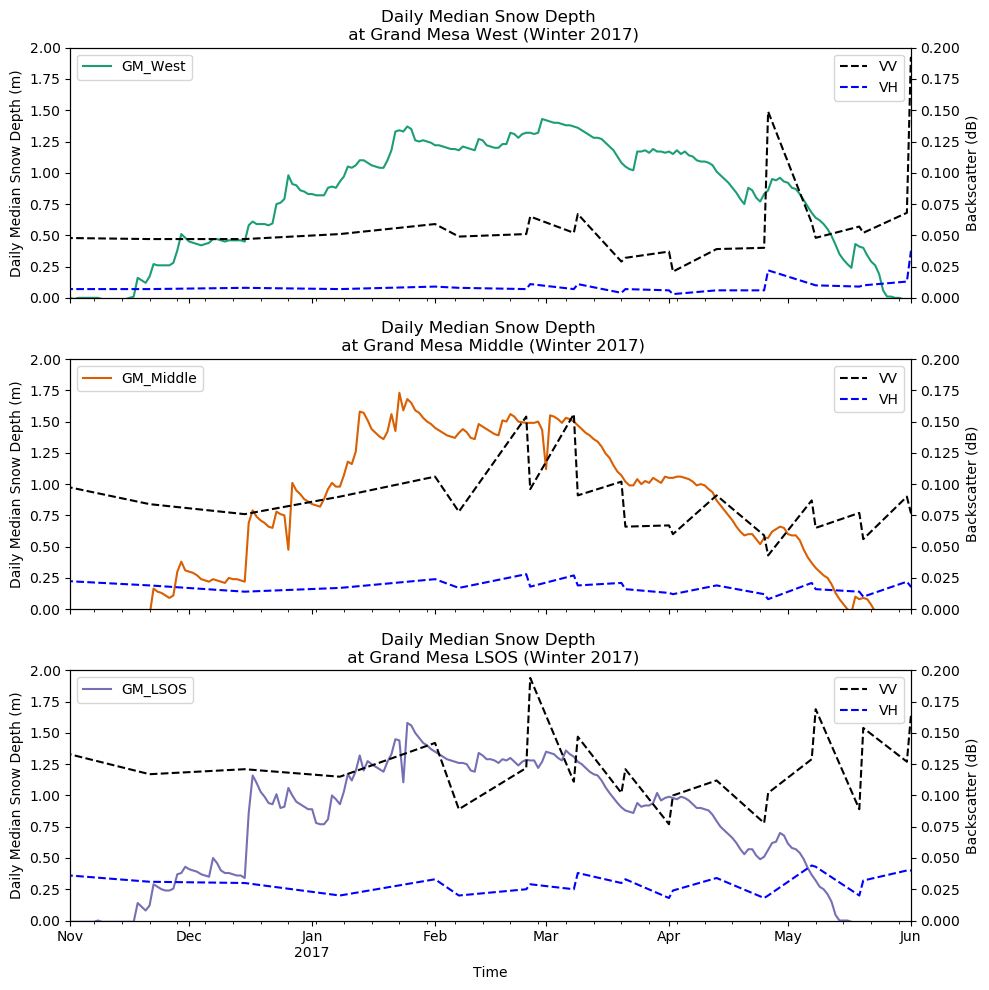

In [135]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')

# Plot daily median snow depths:
with plt.style.context('default'):
    fig, ax = plt.subplots(3,1,figsize=(10,10))

    ax[0].set_title('Daily Median Snow Depth \n at Grand Mesa West (Winter 2017)');
    gm_west_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#1b9e77', ax=ax[0], 
                              label='GM_West')
    ax2 = ax[0].twinx() # add a second y axis for the VH/VV data
    gm_west_sentinel1.plot(x='system:time_start',y='VV',
                          c='k',linestyle='--', ax=ax2,
                          label='VV')
    gm_west_sentinel1.plot(x='system:time_start',y='VH',
                          c='b',linestyle='--', ax=ax2,
                          label='VH')
    ax2.set_ylabel('Backscatter (dB)')
    ax2.legend(loc='upper right')
    ax2.set_ylim((0,0.2))

    ax[1].set_title('Daily Median Snow Depth \n at Grand Mesa Middle (Winter 2017)');
    gm_middle_daily_median.plot(y='Snow Depth(m, Avg)', 
                                c='#d95f02', ax=ax[1], 
                                label='GM_Middle')
    ax2 = ax[1].twinx() # add a second y axis for the VH/VV data
    gm_middle_sentinel1.plot(x='system:time_start',y='VV',
                          c='k',linestyle='--', ax=ax2,
                          label='VV')
    gm_middle_sentinel1.plot(x='system:time_start',y='VH',
                          c='b',linestyle='--', ax=ax2,
                          label='VH')
    ax2.set_ylabel('Backscatter (dB)')
    ax2.legend(loc='upper right')
    ax2.set_ylim((0,0.2))

    ax[2].set_title('Daily Median Snow Depth \n at Grand Mesa LSOS (Winter 2017)');
    l1 = gm_lsos_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#7570b3', ax=ax[2], 
                              label='GM_LSOS')
    ax2 = ax[2].twinx() # add a second y axis for the VH/VV data
    gm_lsos_sentinel1.plot(x='system:time_start',y='VV',
                          c='k',linestyle='--', ax=ax2,
                          label='VV')
    gm_lsos_sentinel1.plot(x='system:time_start',y='VH',
                          c='b',linestyle='--', ax=ax2,
                          label='VH')
    ax2.set_ylabel('Backscatter (dB)')
    ax2.legend(loc='upper right')
    ax2.set_ylim((0,0.2))
    
    # format each subplot:
    for n in range(len(ax)):
        ax[n].set_ylim((0,2))
        ax[n].set_xlim((starttime,endtime))
        ax[n].set_ylabel('Daily Median Snow Depth (m)')
        ax[n].set_xlabel('Time')
        ax[n].legend(loc='upper left')
        

    plt.tight_layout()
    plt.savefig('daily_median_snowdepth-and-sentinel-vh-vv.png',dpi=300)

#### Plot surface observations of snow depth (m) versus Sentinel-1 VH/VV backscatter ratio:

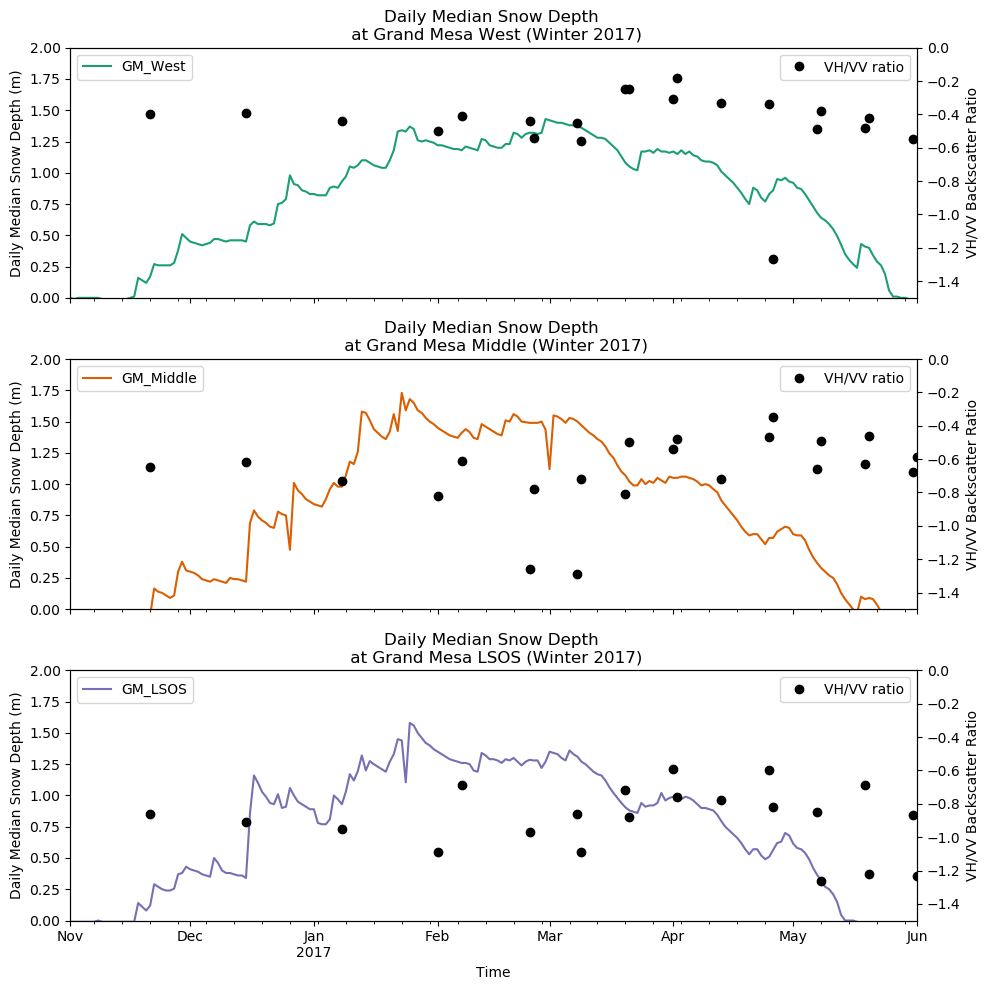

In [137]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')

# Plot daily median snow depths:
with plt.style.context('default'):
    fig, ax = plt.subplots(3,1,figsize=(10,10))

    ax[0].set_title('Daily Median Snow Depth \n at Grand Mesa West (Winter 2017)');
    gm_west_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#1b9e77', ax=ax[0], 
                              label='GM_West')
    ax2 = ax[0].twinx() # add a second y axis for the VH/VV data
    gm_west_sentinel1.plot(x='system:time_start',y='VH/VV',
                          c='k',linestyle='None', marker='o', ax=ax2,
                          label='VH/VV ratio')
    ax2.set_ylabel('VH/VV Backscatter Ratio')
    ax2.legend(loc='upper right')
    ax2.set_ylim((-1.5,0))

    ax[1].set_title('Daily Median Snow Depth \n at Grand Mesa Middle (Winter 2017)');
    gm_middle_daily_median.plot(y='Snow Depth(m, Avg)', 
                                c='#d95f02', ax=ax[1], 
                                label='GM_Middle')
    ax2 = ax[1].twinx() # add a second y axis for the VH/VV data
    gm_middle_sentinel1.plot(x='system:time_start',y='VH/VV',
                          c='k',linestyle='None', marker='o', ax=ax2,
                          label='VH/VV ratio')
    ax2.set_ylabel('VH/VV Backscatter Ratio')
    ax2.legend(loc='upper right')
    ax2.set_ylim((-1.5,0))

    ax[2].set_title('Daily Median Snow Depth \n at Grand Mesa LSOS (Winter 2017)');
    l1 = gm_lsos_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#7570b3', ax=ax[2], 
                              label='GM_LSOS')
    ax2 = ax[2].twinx() # add a second y axis for the VH/VV data
    l2 = gm_lsos_sentinel1.plot(x='system:time_start',y='VH/VV',
                          c='k',linestyle='None', marker='o', ax=ax2,
                          label='VH/VV ratio')
    ax2.set_ylabel('VH/VV Backscatter Ratio')
    ax2.legend(loc='upper right')
    ax2.set_ylim((-1.5,0))
    
    # format each subplot:
    for n in range(len(ax)):
        ax[n].set_ylim((0,2))
        ax[n].set_xlim((starttime,endtime))
        ax[n].set_ylabel('Daily Median Snow Depth (m)')
        ax[n].set_xlabel('Time')
        ax[n].legend(loc='upper left')
        

    plt.tight_layout()
    plt.savefig('daily_median_snowdepth-and-sentinel-vh-vv_ratio.png',dpi=300)

***
#### Plot snow depth versus the VH/VV ratio.
According to Lievens et al. (2019), the VH/VV ratio is better correlated with snow depth (a positive relationship?)

First, find the corresponding snowdepth for each Sentinel-1 observation:

In [90]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

In [91]:
# Grand Mesa West
times = (gm_west_sentinel1['system:time_start'] > starttime) & (gm_west_sentinel1['system:time_start'] < endtime)
snowdepths_west = []
for t in gm_west_sentinel1['system:time_start'][times]:
    insitu_time = nearest(gm_west.datetime,t)
    depth = gm_west['Snow Depth (m, Avg)'][gm_west.datetime == insitu_time].values[0]
    snowdepths_west.append(depth)
snowdepths_west = np.array(snowdepths_west)

In [92]:
# Grand Mesa Middle
times = (gm_middle_sentinel1['system:time_start'] > starttime) & (gm_middle_sentinel1['system:time_start'] < endtime)
snowdepths_middle = []
for t in gm_middle_sentinel1['system:time_start'][times]:
    insitu_time = nearest(gm_middle.datetime,t)
    depth = gm_middle['Snow Depth(m, Avg)'][gm_middle.datetime == insitu_time].values[0]
    snowdepths_middle.append(depth)
snowdepths_middle = np.array(snowdepths_middle)

In [93]:
# Grand Mesa LSOS
times = (gm_lsos_sentinel1['system:time_start'] > starttime) & (gm_lsos_sentinel1['system:time_start'] < endtime)
snowdepths_lsos = []
for t in gm_lsos_sentinel1['system:time_start'][times]:
    insitu_time = nearest(gm_lsos.datetime,t)
    depth = gm_lsos['Snow Depth (m, Avg)'][gm_lsos.datetime == insitu_time].values[0]
    snowdepths_lsos.append(depth)
snowdepths_lsos = np.array(snowdepths_lsos)

Filter out snowdepths less than some threshold:

In [105]:
min_snowdepth = 0.1

# Grand Mesa West
vh_vv_ratio_west = gm_west_sentinel1['VH/VV'][times][snowdepths_west>min_snowdepth]
vh_west = gm_west_sentinel1['VH'][times][snowdepths_west>min_snowdepth]
vv_west = gm_west_sentinel1['VV'][times][snowdepths_west>min_snowdepth]
snowdepth_west = snowdepths_west[snowdepths_west>min_snowdepth]

# Grand Mesa Middle
vh_vv_ratio_middle = gm_middle_sentinel1['VH/VV'][times][snowdepths_middle>min_snowdepth]
vh_middle = gm_middle_sentinel1['VH'][times][snowdepths_middle>min_snowdepth]
vv_middle = gm_middle_sentinel1['VV'][times][snowdepths_middle>min_snowdepth]
snowdepth_middle = snowdepths_middle[snowdepths_middle>min_snowdepth]

# Grand Mesa LSOS
vh_vv_ratio_lsos = gm_lsos_sentinel1['VH/VV'][times][snowdepths_lsos>min_snowdepth]
vh_lsos = gm_lsos_sentinel1['VH'][times][snowdepths_lsos>min_snowdepth]
vv_lsos = gm_lsos_sentinel1['VV'][times][snowdepths_lsos>min_snowdepth]
snowdepth_lsos = snowdepths_lsos[snowdepths_lsos>min_snowdepth]

Snowdepth versus VH/VV ratio plots:

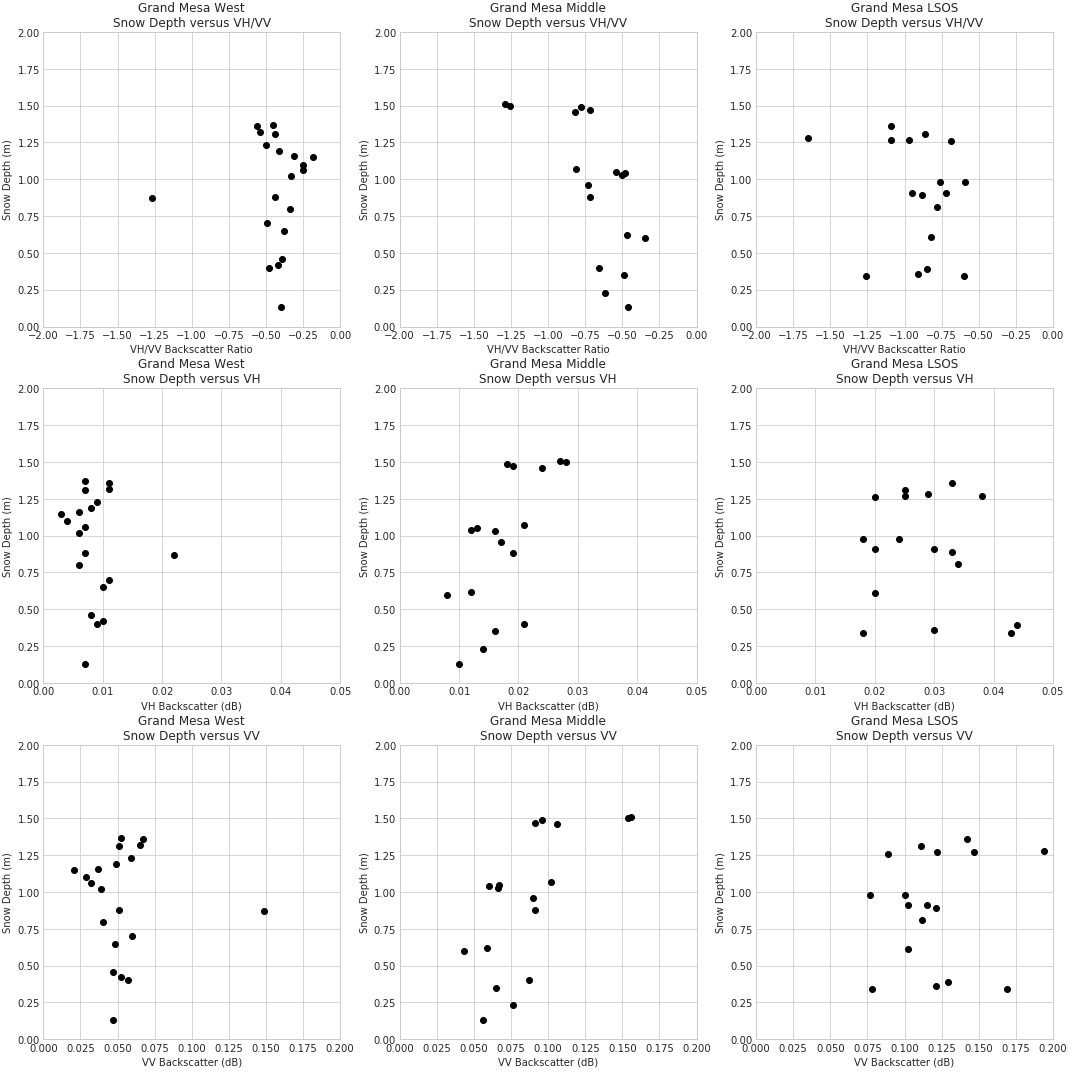

In [138]:
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots(3,3,figsize=(15,15))
        
    # VH/VV Ratio
    # GM West
    ax[0,0].plot(vh_vv_ratio_west,snowdepth_west, 'ok')
    ax[0,0].set_title('Grand Mesa West\nSnow Depth versus VH/VV')                 
    # GM Middle
    ax[0,1].plot(vh_vv_ratio_middle,snowdepth_middle, 'ok')
    ax[0,1].set_title('Grand Mesa Middle\nSnow Depth versus VH/VV')
    # GM LSOS
    ax[0,2].plot(vh_vv_ratio_lsos,snowdepth_lsos, 'ok')
    ax[0,2].set_title('Grand Mesa LSOS\nSnow Depth versus VH/VV')
    

    
    # VH
    # GM West
    ax[1,0].plot(vh_west,snowdepth_west, 'ok')
    ax[1,0].set_title('Grand Mesa West\nSnow Depth versus VH')                 
    # GM Middle
    ax[1,1].plot(vh_middle,snowdepth_middle, 'ok')
    ax[1,1].set_title('Grand Mesa Middle\nSnow Depth versus VH')
    # GM LSOS
    ax[1,2].plot(vh_lsos,snowdepth_lsos, 'ok')
    ax[1,2].set_title('Grand Mesa LSOS\nSnow Depth versus VH')
    
    # VV
    # GM West
    ax[2,0].plot(vv_west,snowdepth_west, 'ok')
    ax[2,0].set_title('Grand Mesa West\nSnow Depth versus VV')                 
    # GM Middle
    ax[2,1].plot(vv_middle,snowdepth_middle, 'ok')
    ax[2,1].set_title('Grand Mesa Middle\nSnow Depth versus VV')
    # GM LSOS
    ax[2,2].plot(vv_lsos,snowdepth_lsos, 'ok')
    ax[2,2].set_title('Grand Mesa LSOS\nSnow Depth versus VV')
                         
    for row in range(ax.shape[1]):
        for col in range(ax.shape[0]):
            ax[col,row].set_ylabel('Snow Depth (m)')
            ax[col,row].set_ylim((0,2))
            if col == 0:
                ax[col,row].set_xlim((-2,0))
                ax[col,row].set_xlabel('VH/VV Backscatter Ratio')
            if col == 1:
                ax[col,row].set_xlim((0,0.05))
                ax[col,row].set_xlabel('VH Backscatter (dB)')
            if col == 2:
                ax[col,row].set_xlim((0,0.2))
                ax[col,row].set_xlabel('VV Backscatter (dB)')

    plt.tight_layout()
    plt.savefig('snowdepth-versus-vh_vv_ratio.png',dpi=300)

### Plot VH/VV at each site, look at it as a function of local forest cover

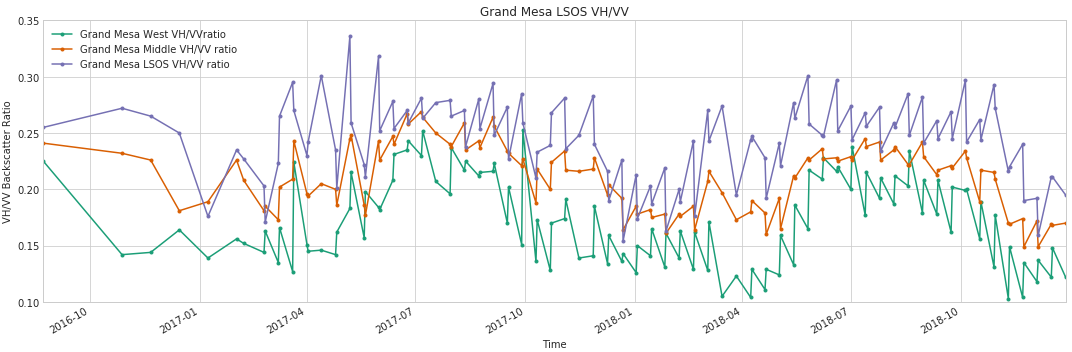

In [164]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')
plt.rcParams.update({'font.size': 10})
# Plot daily median snow depths:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.set_title('Grand Mesa West VH/VV') 
    gm_west_sentinel1.plot(x='system:time_start',y='VH_VV_ratio',
                          c='#1b9e77',linestyle='-', marker='.', ax=ax,
                          label='Grand Mesa West VH/VVratio')
    
    ax.set_title('Grand Mesa Middle VH/VV') 
    gm_middle_sentinel1.plot(x='system:time_start',y='VH_VV_ratio',
                          c='#d95f02',linestyle='-', marker='.', ax=ax,
                          label='Grand Mesa Middle VH/VV ratio')
    
    ax.set_title('Grand Mesa LSOS VH/VV') 
    gm_lsos_sentinel1.plot(x='system:time_start',y='VH_VV_ratio',
                          c='#7570b3',linestyle='-', marker='.', ax=ax,
                          label='Grand Mesa LSOS VH/VV ratio')
  

    #ax[n].set_ylim((-1.5,0))
    ax.set_ylim((0.1,0.35))
    #ax[n].set_xlim((starttime,endtime))
    ax.set_ylabel('VH/VV Backscatter Ratio')
    ax.set_xlabel('Time')
    ax.legend(loc='upper left')
        

    plt.tight_layout()
    plt.savefig('sentinel-vh-vv_ratio.png',dpi=300)

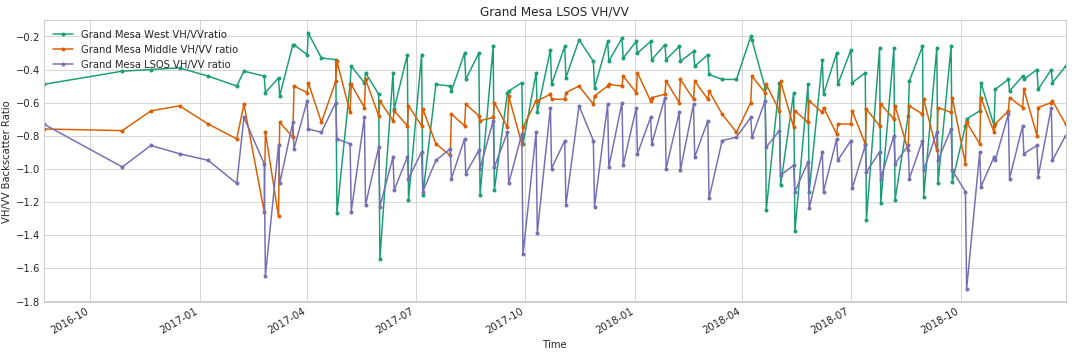

In [165]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')
plt.rcParams.update({'font.size': 10})
# Plot daily median snow depths:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.set_title('Grand Mesa West VH/VV') 
    gm_west_sentinel1.plot(x='system:time_start',y='VH/VV',
                          c='#1b9e77',linestyle='-', marker='.', ax=ax,
                          label='Grand Mesa West VH/VVratio')
    
    ax.set_title('Grand Mesa Middle VH/VV') 
    gm_middle_sentinel1.plot(x='system:time_start',y='VH/VV',
                          c='#d95f02',linestyle='-', marker='.', ax=ax,
                          label='Grand Mesa Middle VH/VV ratio')
    
    ax.set_title('Grand Mesa LSOS VH/VV') 
    gm_lsos_sentinel1.plot(x='system:time_start',y='VH/VV',
                          c='#7570b3',linestyle='-', marker='.', ax=ax,
                          label='Grand Mesa LSOS VH/VV ratio')
  

    #ax[n].set_ylim((-1.5,0))
    #ax.set_ylim((0.1,0.35))
    #ax[n].set_xlim((starttime,endtime))
    ax.set_ylabel('VH/VV Backscatter Ratio')
    ax.set_xlabel('Time')
    ax.legend(loc='upper left')
        

    plt.tight_layout()
    plt.savefig('sentinel-vh-vv_ratio2.png',dpi=300)